# Analyzing Bike Demand Dataset

Our objective is to find a predictive model that can estimate bike rental demand for Casual and registered users.

ML workflow is as follows:
1. EDA
2. Establish a baseline regression and compare random forest and LASSO using RMSPE (Root Mean Square Percentage Error) metric
3. Interpret model results

In [1]:
# Importing necessary libraries
# Data manipulation
import pandas as pd 
import numpy as np
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
# working directory
import os
os.getcwd()

'/Users/kavyaannapareddy/Desktop/Projects/python/wip'

In [3]:
# Display columns during print
pd.set_option('display.max_columns', 30)

In [4]:
# reading file
filepath= '/Users/kavyaannapareddy/Desktop/Projects/python/wip/BikeDemandDaily.csv'
bike_df= pd.read_csv(filepath, index_col='Index')

# copying data into variable 'bike' for EDA
bike= bike_df.copy()

# copying data into variable 'bikem' for model application
bike_m= bike_df.copy()



In [5]:
bike_df.head()

,year,month,day,season,holiday,workingday,meanatemp,maxatemp,minatemp,sdatemp,meanhumidity,maxhumidity,minhumidity,sdhumidity,meanwindspeed,maxwindspeed,minwindspeed,sdwindspeed,Casual,Registered,Total
Index,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,0,0,18.181250,22.725,12.880,3.750746,80.583333,94,72,5.904432,10.749871,19.9995,0.0000,8.984065,336,691,1027
2,1,1,2,1,0,0,17.686957,22.725,10.605,3.708014,69.608696,100,39,18.773141,16.652122,30.0026,8.9981,5.087279,131,693,824
3,1,1,3,1,0,1,9.470227,12.880,5.305,2.380840,43.727273,69,30,10.682348,16.636709,27.9993,0.0000,7.550605,128,1238,1366
4,1,1,4,1,0,1,10.606087,14.395,6.820,2.574481,59.043478,74,48,8.977134,10.739809,22.0028,0.0000,5.344103,118,1471,1589
5,1,1,5,1,0,1,11.463478,15.910,9.090,1.845936,43.695652,74,28,13.226814,12.522300,22.0028,0.0000,6.694015,89,1526,1615




# Understanding data
   
Data Fields:

year, month, day

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

atemp - "feels like" temperature in Celsius;  mean, max,min,sd

humidity - relative humidity; mean, max, min, sd

windspeed - wind speed; mean, max, min, sd

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

Total - number of total rentals

In [6]:
# checking if there are any duplicates
bike[bike.duplicated()]

,year,month,day,season,holiday,workingday,meanatemp,maxatemp,minatemp,sdatemp,meanhumidity,maxhumidity,minhumidity,sdhumidity,meanwindspeed,maxwindspeed,minwindspeed,sdwindspeed,Casual,Registered,Total
Index,,,,,,,,,,,,,,,,,,,,,


No duplicated rows

Since, it is a clean dataset,we jump directly to understanding data such as the shape, number of features, target variable, etc. We perform Exploratory data analysis to visualize relationships and to draw some insights from the dataset which will help us in feature Selection. 



#  Exploratory Data Analysis

In [7]:
bike.shape

(456, 21)

The dataset has 456 rows and 21 features. The numerical features include temperature, humdity , windspeed. the categorical features are season, holiday and working day.  The target variable is the demand of bikes: casual and Registered.

In [8]:
bike.dtypes

year               int64
month              int64
day                int64
season             int64
holiday            int64
workingday         int64
meanatemp        float64
maxatemp         float64
minatemp         float64
sdatemp          float64
meanhumidity     float64
maxhumidity        int64
minhumidity        int64
sdhumidity       float64
meanwindspeed    float64
maxwindspeed     float64
minwindspeed     float64
sdwindspeed      float64
Casual             int64
Registered         int64
Total              int64
dtype: object

In [9]:
# Mapping numerical values to categorical in categorical variables 
bike['season']= bike.season.map({1:'spring',2:'summer', 3:'fall',4:'winter'})
bike['month']= bike.month.map({1:'jan',2:'feb', 3:'mar',4:'apr',
                                5:'may',6:'jun',7:'jul',8:'aug', 
                                9:'sep', 10:'oct', 11:'nov', 12:'dec'})
bike['holiday']= bike.holiday.map({1: 'Yes',0:'No'})
bike['workingday']= bike.workingday.map({1: 'Yes',0:'No'})

In [10]:
# create separate dataframes for numerical and categorical features
num_features_list= ['meanatemp','meanhumidity', 'meanwindspeed']
cat_features_list=['season','holiday','workingday','month', 'day', 'year']
target_list=['Total','Casual','Registered']

In [11]:
# convert categorical features to dtype: category
bike[cat_features_list]= bike[cat_features_list].astype('category')

In [12]:
bike.dtypes

year             category
month            category
day              category
season           category
holiday          category
workingday       category
meanatemp         float64
maxatemp          float64
minatemp          float64
sdatemp           float64
meanhumidity      float64
maxhumidity         int64
minhumidity         int64
sdhumidity        float64
meanwindspeed     float64
maxwindspeed      float64
minwindspeed      float64
sdwindspeed       float64
Casual              int64
Registered          int64
Total               int64
dtype: object

In [13]:
bike.dtypes.value_counts()

float64     10
int64        5
category     2
category     1
category     1
category     1
category     1
dtype: int64

# Missing Values

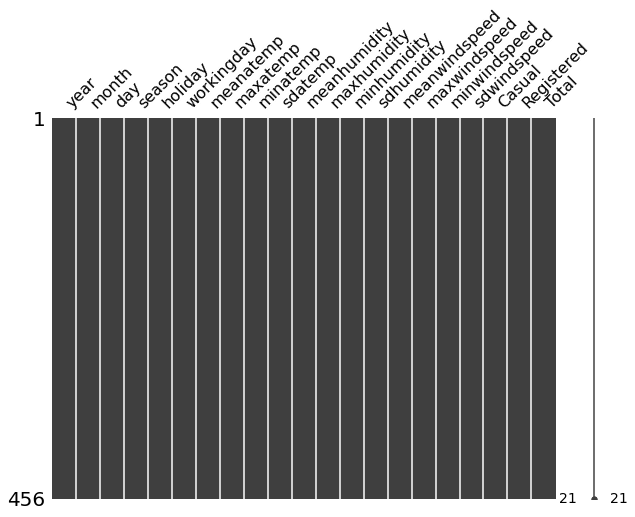

In [14]:
import missingno as mn
mn.matrix(bike, figsize=(10,7))

In [15]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 1 to 456
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   year           456 non-null    category
 1   month          456 non-null    category
 2   day            456 non-null    category
 3   season         456 non-null    category
 4   holiday        456 non-null    category
 5   workingday     456 non-null    category
 6   meanatemp      456 non-null    float64 
 7   maxatemp       456 non-null    float64 
 8   minatemp       456 non-null    float64 
 9   sdatemp        456 non-null    float64 
 10  meanhumidity   456 non-null    float64 
 11  maxhumidity    456 non-null    int64   
 12  minhumidity    456 non-null    int64   
 13  sdhumidity     456 non-null    float64 
 14  meanwindspeed  456 non-null    float64 
 15  maxwindspeed   456 non-null    float64 
 16  minwindspeed   456 non-null    float64 
 17  sdwindspeed    456 non-null    floa

In [16]:
bike.describe()

,meanatemp,maxatemp,minatemp,sdatemp,meanhumidity,maxhumidity,minhumidity,sdhumidity,meanwindspeed,maxwindspeed,minwindspeed,sdwindspeed,Casual,Registered,Total
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,23.606959,27.764419,19.542566,2.726107,61.889357,81.519737,42.842105,12.483867,12.805332,24.541880,2.439050,6.204946,864.929825,3733.122807,4598.052632
std,8.004275,8.147327,7.992150,1.030658,14.192906,13.684982,14.921673,4.713825,5.129944,8.054081,4.156183,1.923500,698.733494,1494.076738,1868.243786
min,5.082917,8.335000,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500242,8.998100,0.000000,2.244805,11.000000,516.000000,635.000000
25%,16.989479,21.210000,12.120000,1.981166,51.218750,72.750000,33.000000,9.025025,9.199956,19.001200,0.000000,4.863737,324.250000,2719.500000,3328.750000
50%,24.494896,30.305000,20.455000,2.689348,61.854167,83.000000,40.500000,12.313536,12.146123,23.999400,0.000000,5.877072,725.000000,3725.500000,4611.500000
75%,30.088662,33.335000,25.948750,3.389793,71.843750,93.000000,51.000000,15.687048,15.612960,30.002600,6.003200,7.327256,1150.000000,4826.500000,6007.500000
max,40.245625,45.455000,35.605000,5.839720,97.041667,100.000000,88.000000,31.647945,33.999988,56.996900,19.999500,13.708971,3410.000000,6949.000000,8736.000000


The minimum values of  humidity and min wind speed are 0. Need to inspect further if need to be removed or inputted with a value

# Univariate Analysis - Numerical Features

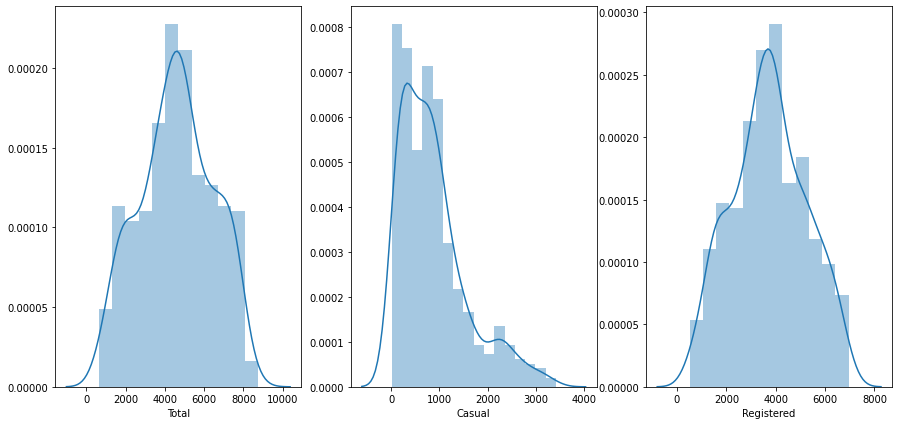

In [17]:
#Distribution of target variable
fig, ax= plt.subplots(1,3, figsize= (15,7))
for i, ax in enumerate(fig.axes):
    sns.distplot(bike[target_list[i]], ax=ax)

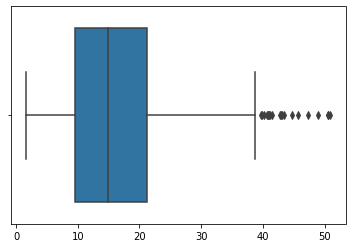

In [18]:
# percentage of casual users to Total users in the dataset
sns.boxplot((bike['Casual']/bike['Total']).mul(100))

The registered users' bike rentals are much higher than that of causal users. The rentals of casual users are skewed to the right, could be due to excess demand in particular season/months of the year. The maximum share of casual users to the Total is 50%. The median is about 15%. Since registered users make a larger part of the Total users, their distributions resemble one another. 

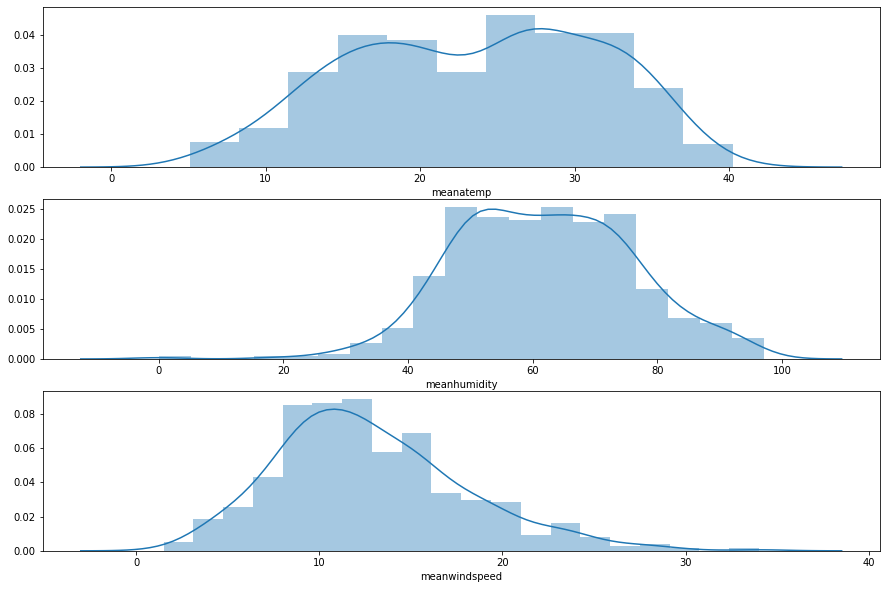

In [19]:
# Plot distribution for mean values of  atemp, humidty and winspeed
fig, ax= plt.subplots(3,1, figsize=(15,10))
for i, ax in enumerate(fig.axes):
    sns.distplot( bike[num_features_list[i]], ax=ax )

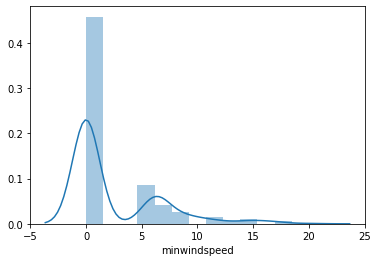

In [20]:
sns.distplot(bike['minwindspeed'])

# Outlier Analysis- remove or keep them?

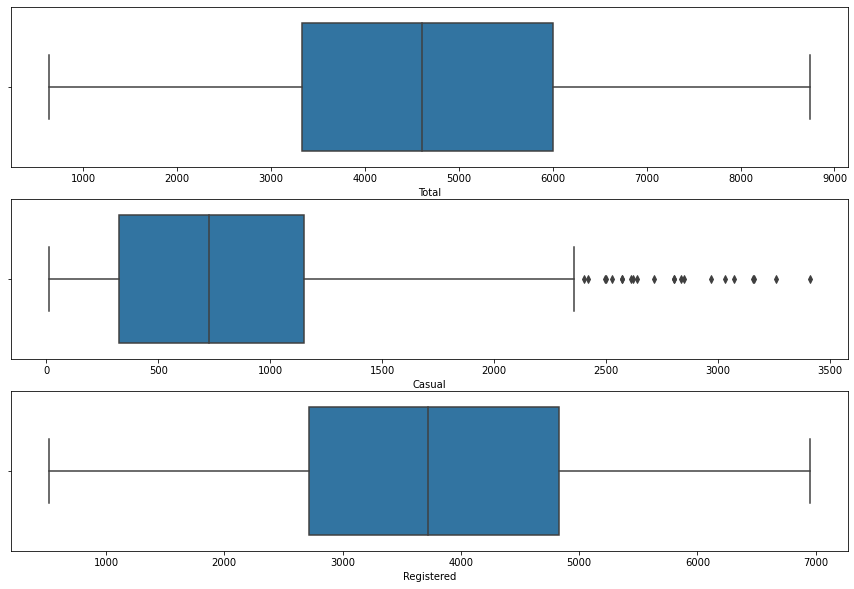

In [21]:
fig, ax= plt.subplots(3,1, figsize=(15,10))
for i, ax in enumerate(fig.axes):
    sns.boxplot(x= target_list[i], data= bike, ax=ax)

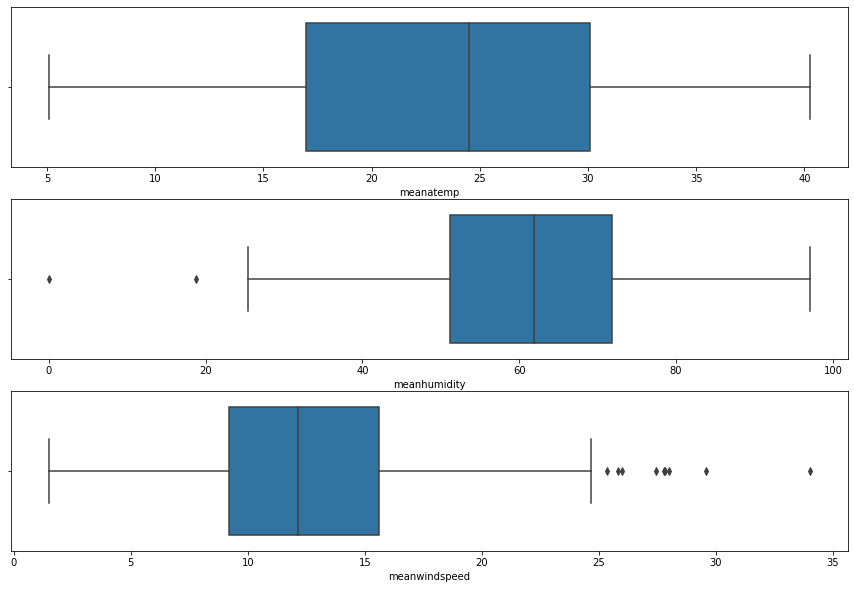

In [22]:
# Plot boxplots for mean values of  atemp, humidty and winspeed
fig, ax= plt.subplots(3,1, figsize=(15,10))
for i, ax in enumerate(fig.axes):
    sns.boxplot(x= num_features_list[i], data=bike, ax=ax )

The dataset constains some instances of extreme wind speed which could further be studied. But for now, I let them be. However, of the 2 outliers in mean humidity, one instance is at 0%, a level which is almost impossible on Earth. It could a case of missing value converted to zero during data cleaning phase. Instead of inputing a new value, I decided to delete that row of datapoints. 

In [23]:
bike.sort_values(['meanhumidity'])

,year,month,day,season,holiday,workingday,meanatemp,maxatemp,minatemp,sdatemp,meanhumidity,maxhumidity,minhumidity,sdhumidity,meanwindspeed,maxwindspeed,minwindspeed,sdwindspeed,Casual,Registered,Total
Index,,,,,,,,,,,,,,,,,,,,,
48,1,mar,10,spring,No,Yes,19.283409,21.970,15.91,2.357861,0.000000,0,0,0.000000,17.545777,39.0007,6.0032,6.660129,47,602,649
38,1,feb,19,spring,No,No,19.570208,23.485,12.12,3.465505,18.791667,33,12,5.867961,33.999988,50.0021,19.9995,8.010335,539,1139,1678
292,2,apr,7,summer,No,No,21.306458,25.760,15.15,3.819605,25.416667,36,16,6.240935,18.416346,27.9993,11.0014,5.166590,3260,3635,6895
293,2,apr,8,summer,No,No,24.621250,30.305,18.94,3.921510,27.583333,46,17,7.395161,15.583921,30.0026,0.0000,8.027128,2231,2961,5192
97,1,jun,2,summer,No,Yes,32.197083,34.090,31.06,1.023632,30.500000,44,20,7.483315,19.583263,35.0008,0.0000,9.122087,745,4238,4983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,1,nov,16,winter,No,Yes,22.599375,23.485,21.21,0.576894,93.000000,100,88,3.822132,9.167554,26.0027,0.0000,8.308072,154,1686,1840
160,1,sep,8,fall,No,Yes,27.768043,33.335,25.00,1.905399,93.956522,100,79,5.004346,12.914104,26.0027,0.0000,7.291629,163,1727,1890
44,1,mar,6,spring,No,No,18.312609,22.725,9.09,4.644836,94.826087,100,77,7.952428,23.000226,40.9973,15.0013,6.141480,119,516,635


In [24]:
bike= bike.drop(index= 48).reset_index()

In [25]:
bike

,Index,year,month,day,season,holiday,workingday,meanatemp,maxatemp,minatemp,sdatemp,meanhumidity,maxhumidity,minhumidity,sdhumidity,meanwindspeed,maxwindspeed,minwindspeed,sdwindspeed,Casual,Registered,Total
0,1,1,jan,1,spring,No,No,18.181250,22.725,12.880,3.750746,80.583333,94,72,5.904432,10.749871,19.9995,0.0000,8.984065,336,691,1027
1,2,1,jan,2,spring,No,No,17.686957,22.725,10.605,3.708014,69.608696,100,39,18.773141,16.652122,30.0026,8.9981,5.087279,131,693,824
2,3,1,jan,3,spring,No,Yes,9.470227,12.880,5.305,2.380840,43.727273,69,30,10.682348,16.636709,27.9993,0.0000,7.550605,128,1238,1366
3,4,1,jan,4,spring,No,Yes,10.606087,14.395,6.820,2.574481,59.043478,74,48,8.977134,10.739809,22.0028,0.0000,5.344103,118,1471,1589
4,5,1,jan,5,spring,No,Yes,11.463478,15.910,9.090,1.845936,43.695652,74,28,13.226814,12.522300,22.0028,0.0000,6.694015,89,1526,1615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,452,2,dec,15,winter,No,No,16.919167,21.210,12.880,2.611119,65.041667,87,47,11.983609,7.125450,16.9979,0.0000,5.101255,768,4304,5072
451,453,2,dec,16,winter,No,No,18.496875,20.455,16.665,1.136513,83.875000,93,62,6.713468,6.749692,12.9980,0.0000,4.502822,538,3253,3791
452,454,2,dec,17,winter,No,Yes,20.075000,21.210,17.425,1.070806,90.708333,100,87,3.850231,6.583308,16.9979,0.0000,5.822208,222,4379,4601
453,455,2,dec,18,winter,No,Yes,20.485417,24.240,16.665,2.315825,66.625000,94,41,21.526147,14.834079,32.9975,0.0000,9.648945,441,5139,5580


In [26]:
bike_m = bike_m.drop(index= 48).reset_index()


# Categorical Features

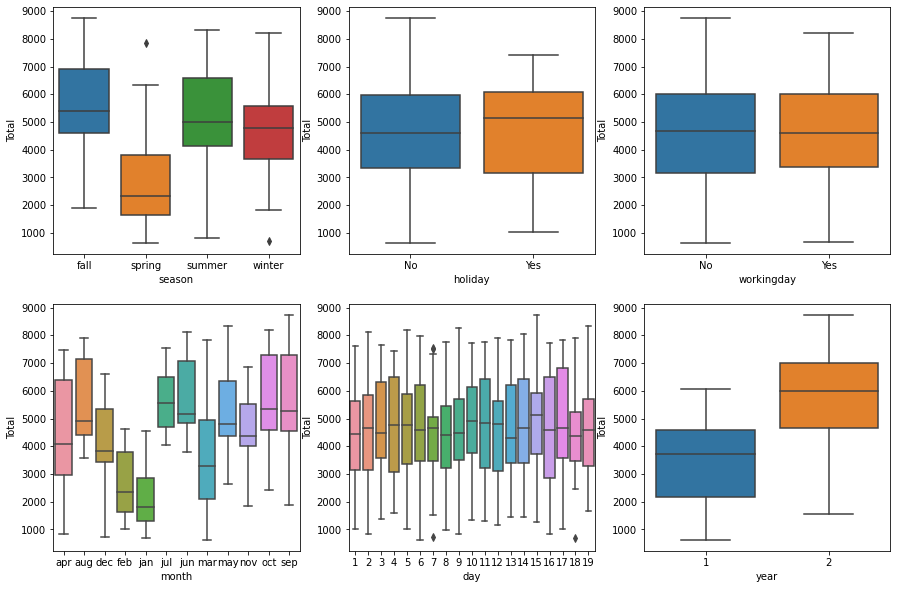

In [27]:
# Plot categorical features with Total bike rentals
fig, ax= plt.subplots(round(len(cat_features_list)/3),3, figsize=(15,10))
for i, ax in enumerate(fig.axes):
    sns.boxplot(x= cat_features_list[i], y='Total', data=bike, ax=ax)

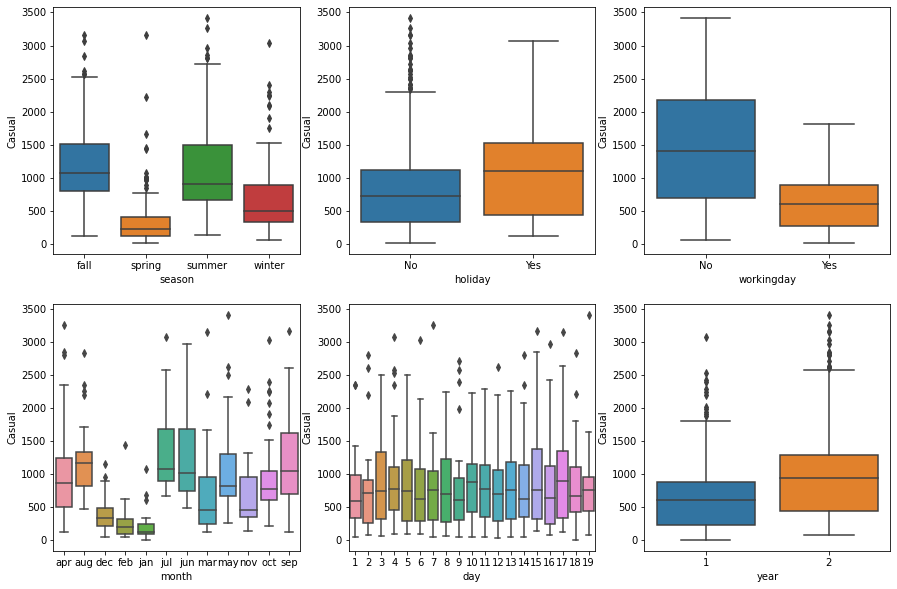

In [28]:
# Plot categorical features with Casual bike rentals
fig, ax= plt.subplots(round(len(cat_features_list)/3),3, figsize=(15,10))
for i, ax in enumerate(fig.axes):
    sns.boxplot(x= cat_features_list[i], y='Casual', data=bike, ax=ax)
    
    

Spring has the least demand from casual bikers followed by Winter. There is more demand during holidays than otherwise and  rent bikes even less if it is a working day. Casual bikers have most demand on weekends. There seems to be an increase in demand in year 2 from year 1. Overall, there are more outliers due to casual bikers not being very consistent in their demand. 

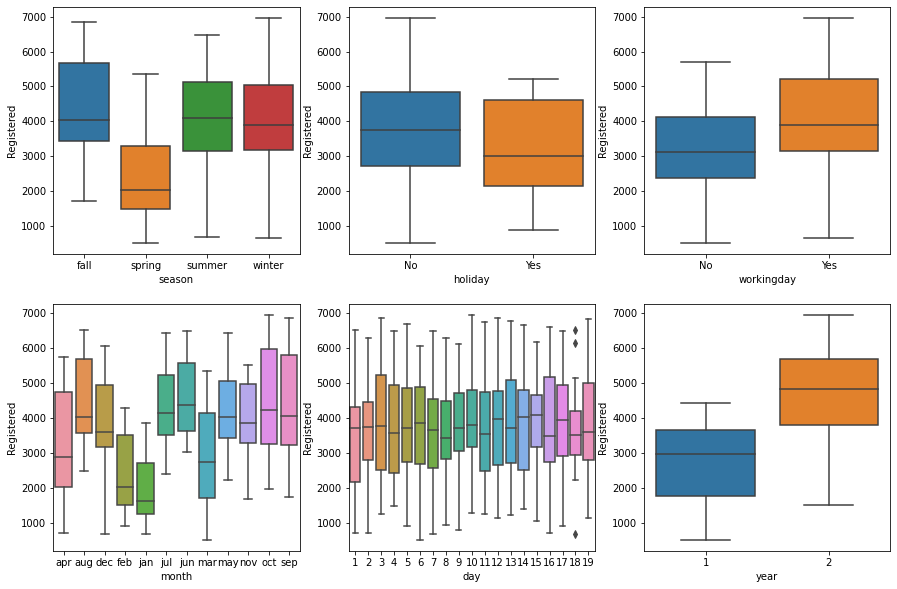

In [29]:
# Plot categorical features with Registered bike rentals
fig, ax= plt.subplots(round(len(cat_features_list)/3),3, figsize=(15,10))
for i, ax in enumerate(fig.axes):
    sns.boxplot(x= cat_features_list[i], y='Registered', data=bike, ax=ax)

The registered bike users are more consistent in their usage compared to casual renters. While Sping has the least demand, the rest of the seasons have persistent demand. They have more demand if it is a working day, implying that the users could be using the bikes for commuting to and from work. However, they do still have demand for bikes on non-holidays and weekends. There are 3 outliers on day 18 and none on the rest of the days.   

# Bivariate Analysis

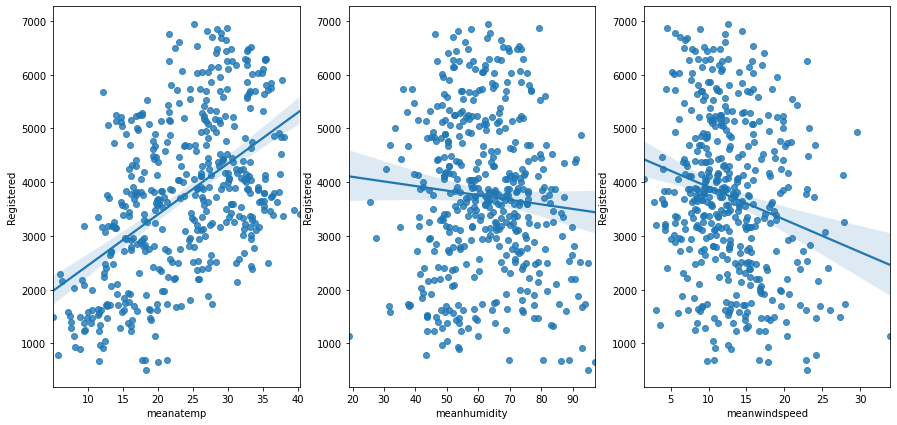

In [30]:

fig, ax= plt.subplots(1,3, figsize=(15,7))
for i, ax in enumerate(fig.axes):
    sns.regplot(x= num_features_list[i], y= 'Registered', data= bike, ax= ax)



meanatemp seems to be a good predictor variable compared to the rest two

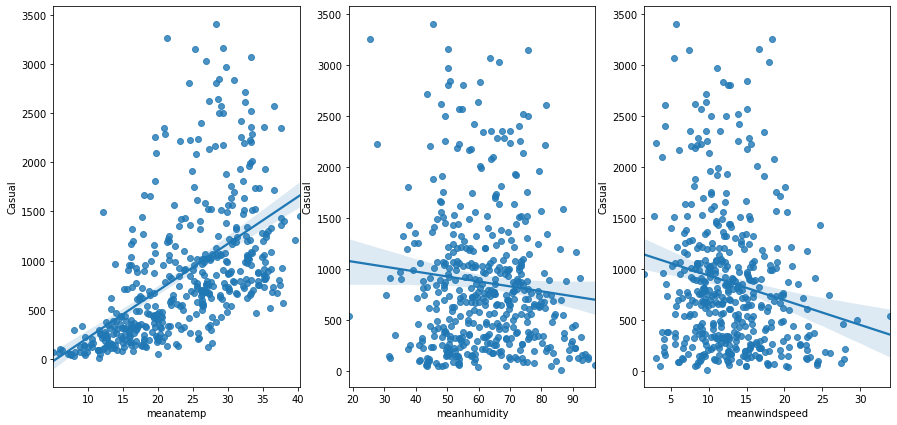

In [31]:

fig, ax= plt.subplots(1,3, figsize=(15,7))
for i, ax in enumerate(fig.axes):
    sns.regplot(x= num_features_list[i], y= 'Casual', data= bike, ax= ax)

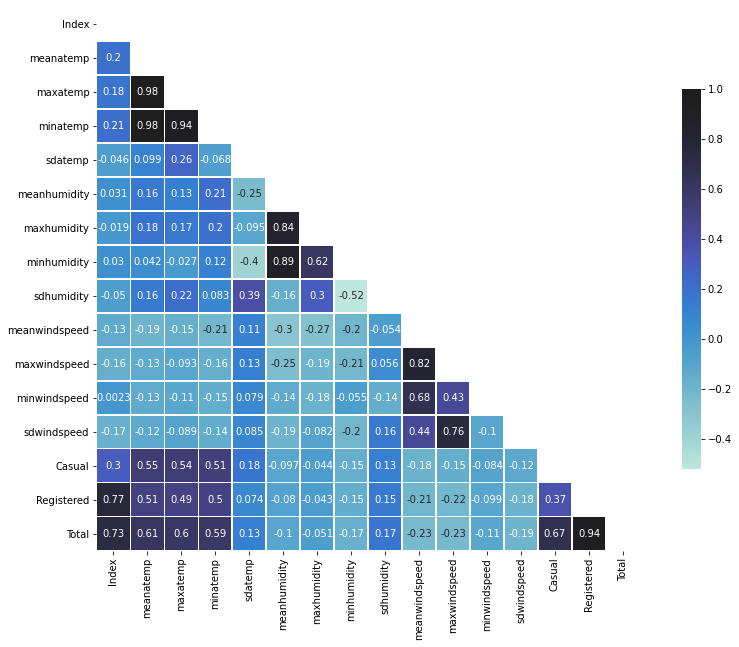

In [32]:
# heat map 
corr= bike.corr()
# create a mask for upper triangle
mask= np.triu(np.ones_like(corr, dtype= np.bool))
# set up the matplotlib figure
fig, ax= plt.subplots( figsize= (15,10))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask= mask, 
           center= True, annot= True, square= True, linewidth= 0.5, 
           cbar_kws={'shrink':0.7})

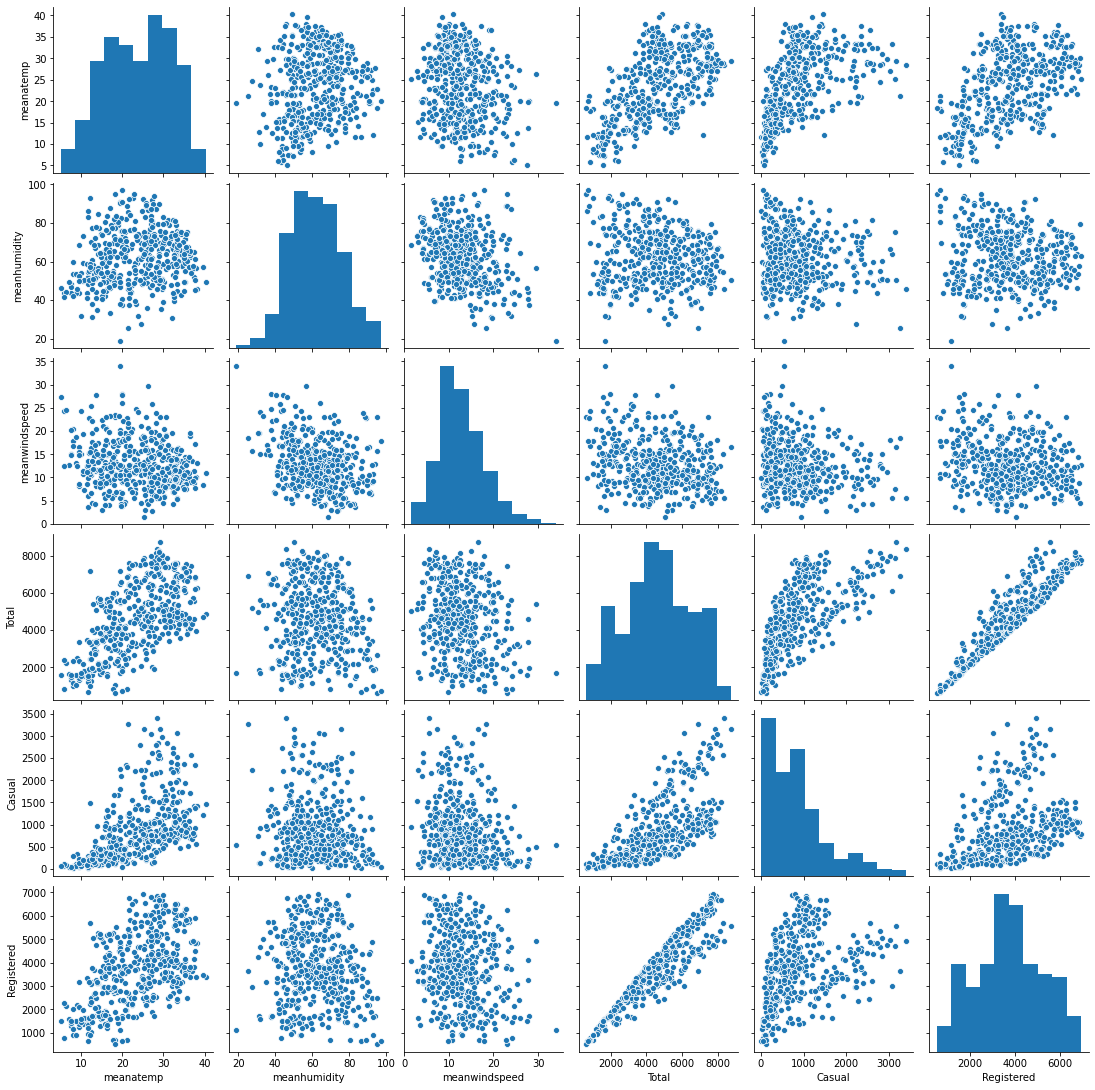

In [33]:
features_list= ['meanatemp','meanhumidity', 'meanwindspeed','season',
                'holiday','workingday','Total','Casual','Registered']
sns.pairplot(bike[features_list])

Temperature seems to have a strong effect on demand for bikes compared to humidity and windspeed

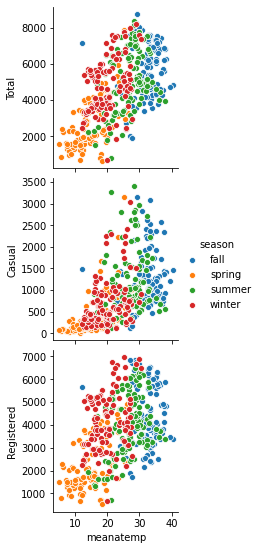

In [34]:
sns.pairplot(x_vars= 'meanatemp', y_vars= target_list ,hue='season', data= bike )

As the temperatures increase, there is increase in bike rental demand. Spring has the lowest temperatures and the least demand. As temperatures increase in summer and fall, there are more users. Summer momths are: april, May , June and Fall momths are: july, august and September

In [35]:
# Understanding Demand month-wise
bike_t_monthly= bike.groupby('month')['Total'].mean()
bike_t_monthly

month
apr    4432.342105
aug    5642.973684
dec    4238.947368
feb    2636.236842
jan    2126.026316
jul    5673.947368
jun    5830.236842
mar    3614.675676
may    5289.684211
nov    4667.026316
oct    5484.815789
sep    5617.763158
Name: Total, dtype: float64

In [36]:
bike_t_monthly= pd.DataFrame(bike_t_monthly).reset_index(drop= False)


In [37]:
bike_t_monthly

,month,Total
0,apr,4432.342105
1,aug,5642.973684
2,dec,4238.947368
3,feb,2636.236842
4,jan,2126.026316
5,jul,5673.947368
6,jun,5830.236842
7,mar,3614.675676
8,may,5289.684211
9,nov,4667.026316


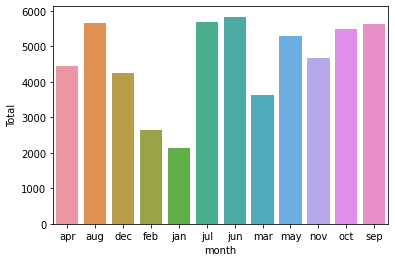

In [38]:
sns.barplot(x= 'month', y= 'Total', data= bike_t_monthly)

In [39]:
bike_casual_monthly= bike.groupby('month')['Casual'].mean()
bike_c_monthly= pd.DataFrame(bike_casual_monthly).reset_index(drop=False)


In [40]:
bike_registered_monthly= bike.groupby('month')['Registered'].mean()
bike_r_monthly= pd.DataFrame(bike_registered_monthly).reset_index(drop= False)
bike_r_monthly

,month,Registered
0,apr,3379.789474
1,aug,4430.052632
2,dec,3847.210526
3,feb,2386.789474
4,jan,1930.078947
5,jul,4328.500000
6,jun,4546.710526
7,mar,2933.486486
8,may,4198.526316
9,nov,3994.631579


In [41]:
# importing library to sort months from Jan- Dec
from sort_dataframeby_monthorweek import Sort_Dataframeby_Month

In [42]:
bike_r_monthly_sort= Sort_Dataframeby_Month(df=bike_r_monthly ,monthcolumnname='month')

In [43]:
bike_c_monthly_sort= Sort_Dataframeby_Month(df= bike_c_monthly, monthcolumnname= 'month')

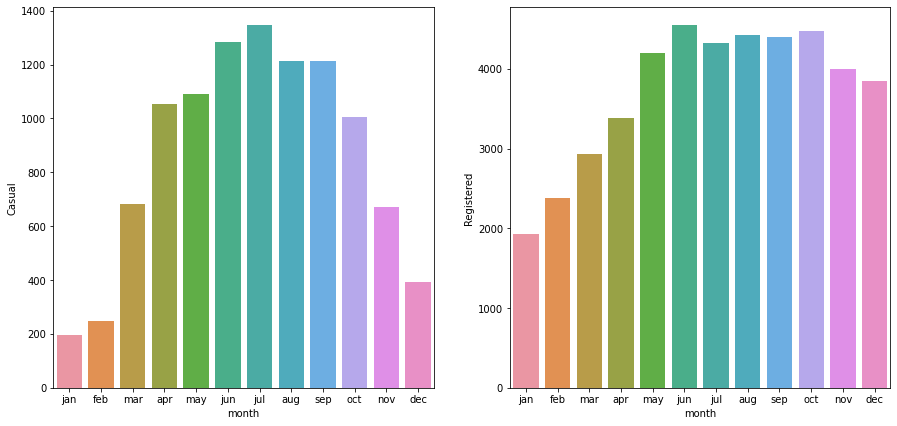

In [44]:
fig,(ax1, ax2)= plt.subplots(1,2, figsize=(15,7))
sns.barplot(x='month', y= 'Casual', data= bike_c_monthly_sort, ax=ax1)
sns.barplot(x= 'month', y= 'Registered', data= bike_r_monthly_sort, ax= ax2)

Text(0.5, 1.0, 'Registered user demand per season: holiday or not ')

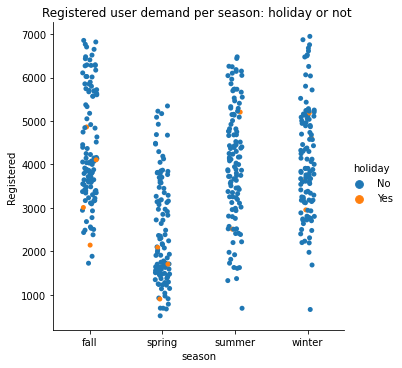

In [45]:
sns.catplot(x='season', y='Registered', hue='holiday', data= bike)
plt.title('Registered user demand per season: holiday or not ')

Text(0.5, 1.0, 'Registred user demand per season : working day or not')

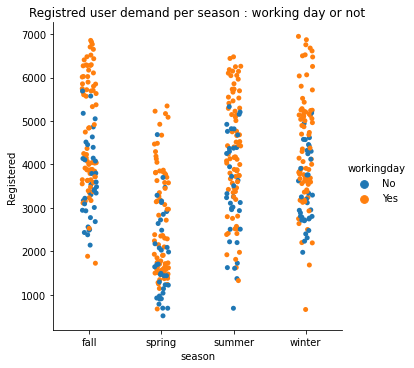

In [46]:
sns.catplot(x='season', y='Registered', hue='workingday', data= bike)
plt.title('Registred user demand per season : working day or not')

Registered users are more consistent in their usage both on working days and on weekends. However, on holidays, there is a fall in demand.

Text(0.5, 1.0, 'Casual user demand per season: holiday or not ')

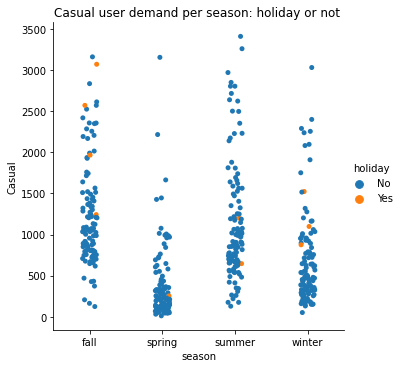

In [47]:
sns.catplot(x='season', y='Casual', hue='holiday', data= bike)
plt.title('Casual user demand per season: holiday or not ')

Text(0.5, 1.0, 'Casual user demand per season : working day or not')

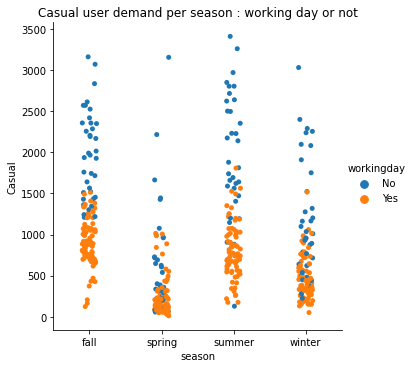

In [48]:
sns.catplot(x='season', y='Casual', hue='workingday', data= bike)
plt.title('Casual user demand per season : working day or not')

Fall and summer seem to have most usage amongst casual users due to good weather. There seems to be a spike in demand from casual users in months of summer and fall during holidays and weekends. 

# Model application

From my EDA, I deduce that meanatemp, season, holiday and workingday are good explanatory variables. the variables minhumidty and meanwindspeed seem to exert some influence too. Of them season, holiday and workingday are categorical variables which have been label encoded. However, for season, label encoding alone isn't sufficient.The model might assume that higher the categorical value, better the category. In our case: 1- spring, 2- summer, 3- fall, 4- winter. Therefore, winter > fall > summer > spring. But, that isn't the case. So, we apply One Hot Encoding to make the seasons category binary. One could do it by using pd.get_dummies or the scikit-learn library. I'm using the former. 

In [49]:
df_dummies= pd.get_dummies(bike['season'], prefix='season')

In [50]:
df_dummies

,season_fall,season_spring,season_summer,season_winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
450,0,0,0,1
451,0,0,0,1
452,0,0,0,1
453,0,0,0,1


In [51]:
bike_new= pd.concat([bike_m,df_dummies], axis=1)


In [52]:
bike_new.columns

Index(['Index', 'year', 'month', 'day', 'season', 'holiday', 'workingday',
       'meanatemp', 'maxatemp', 'minatemp', 'sdatemp', 'meanhumidity',
       'maxhumidity', 'minhumidity', 'sdhumidity', 'meanwindspeed',
       'maxwindspeed', 'minwindspeed', 'sdwindspeed', 'Casual', 'Registered',
       'Total', 'season_fall', 'season_spring', 'season_summer',
       'season_winter'],
      dtype='object')

In [53]:
# reading into X and Y variables - Registered users and Casual Users
features_list= ['meanatemp','minhumidity','meanwindspeed','holiday','workingday','season_fall','season_spring','season_summer','season_winter']
x= np.array(bike_new[features_list])
y_r= np.array(bike_new['Registered'])
y_c= np.array(bike_new['Casual'])

In [54]:
x.shape

(455, 9)

In [55]:
y_r.shape

(455,)

# Establish error metric - RMSPE (Root Mean Square Percentage Error), taken from Chenglong Chen, Kaggle


In [56]:

# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [57]:
# Splitting data set into test and train

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# For Registered Users
x_train, x_test, y_r_train, y_r_test= train_test_split(x, y_r, random_state= 42)


In [60]:
# Linear Regression for registered users
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
lr.fit(x_train, y_r_train)
y_r_pred_linear= lr.predict(x_test)


In [61]:
# RMSPE for Linear regression
rmspe_r_linear= rmspe(y_r_test, y_r_pred_linear)
rmspe_r_linear

0.3074956140013748

In [62]:
# Random Forest for registred users
from sklearn.ensemble import RandomForestRegressor 
rf= RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_r_train)
y_r_pred_rf= rf.predict(x_test)

In [63]:
# RMSPE for Random Forest with 100 trees
rmspe_r_rf= rmspe(y_r_test,y_r_pred_rf )
rmspe_r_rf

0.3274047422391505

Determine the optimal value of aplha for Lasso

In [64]:
# LASSO for Registered users
from sklearn.linear_model import Lasso
clf= Lasso(alpha= 1)
clf.fit(x_train, y_r_train)
y_r_pred_clf= clf.predict(x_test)

In [65]:
# RMSPE for Lasso Regression 
rmspe_r_clf= rmspe(y_r_test, y_r_pred_clf)
rmspe_r_clf

0.3073848050369481

In [66]:
# For casual users
x_train, x_test, y_c_train, y_c_test = train_test_split(x, y_c, random_state= 42)

In [67]:
# Linear Regression for Casual users
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
lr.fit(x_train, y_c_train)
y_c_pred_linear= lr.predict(x_test)
# RMSPE for Linear regression
rmspe_c_linear= rmspe(y_c_test, y_c_pred_linear)
rmspe_c_linear


1.8584910609147975

In [68]:
# Random Forest for Casual users
from sklearn.ensemble import RandomForestRegressor 
rf= RandomForestRegressor(n_estimators=100)
rf.fit(x_train, y_c_train)
y_c_pred_rf= rf.predict(x_test)
# RMSPE for Random Forest with 100 trees
rmspe_c_rf= rmspe(y_c_test,y_c_pred_rf )
rmspe_c_rf

0.6079807662040725

In [69]:
# LASSO for Casual users
from sklearn.linear_model import Lasso
clf= Lasso(alpha= 1)
clf.fit(x_train, y_c_train)
y_c_pred_clf= clf.predict(x_test)
# RMSPE for Lasso Regression 
rmspe_c_clf= rmspe(y_c_test, y_c_pred_clf)
rmspe_c_clf

1.6134251993901496

Mean RMSPE   | Registered  | Casual
                 
Regression  |  0.307  |  1.85 

Random Forest(100 trees)  |  0.328  |  0.619

Lasso(alpha =1)  |  0.306  |  1.613

In case of Registered users, simple linear regression does a good job with the least RMSPE. Whereas Random Forest is better at predicting bike rental for casual users as their demand is less consistent compared to registered users. 